
# PRISMA vs EnMAP: Smile, Striping, and SNR Comparison

This notebook juxtaposes spectral smile, destriping diagnostics, and signal-to-noise ratio (SNR) metrics for the same PRISMA and EnMAP scenes used in `SNR_experiments_prisma.ipynb` and `SNR_experiments_enmap.ipynb`. SNR comparisons use the columnwise, PCA fourth-component configuration (case D in the prior notebooks) with no destriping applied; the PRISMA curves are brightness-normalised to the EnMAP radiance through

\[
\mathrm{SNR}(\lambda) \approx \mathrm{SNR}_\mathrm{ref}(\lambda) \, \sqrt{\frac{L(\lambda)}{L_\mathrm{ref}(\lambda)}}
\]

assuming photon shot noise dominance for these bright targets.

**How to read this notebook**
- Begin with the configuration and helper sections to confirm paths and understand how the rescaling is performed.
- Inspect the SNR tables/plots to evaluate how well the scaled PRISMA curves match EnMAP for the chosen case (columnwise variance measured on PCA component 4 of the plain cube).
- Use the smile diagnostics to contrast column-wise wavelength shifts across sensors; larger swings indicate stronger smile and may explain SNR discrepancies.
- Review striping metrics to identify residual columnar noise patterns that could bias SNR results.

**When the scaling assumption may fail**
- Extremely dark scenes or cases dominated by read noise: the \(\sqrt{L/L_{ref}}\) relationship overestimates PRISMA SNR.
- Scenes with strong atmospheric variability between acquisitions: radiance differences may reflect actual scene change rather than instrument response.
- If destriping or denoising steps differ between the two pipelines, the comparison no longer isolates instrument behaviour.


## Workflow overview

- confirm repository context and configure paths
- load precomputed SNR cases and produce brightness-normalised comparisons
- extract spectral smile diagnostics for matching VNIR/SWIR bands
- characterise striping strength via FFT peak metrics and column statistics

Set the configuration below to point at your local copies if the defaults differ.


In [1]:
import os
import sys
from pathlib import Path

NOTEBOOK_ROOT = Path.cwd().resolve()
REPO_ROOT = NOTEBOOK_ROOT
while not (REPO_ROOT / "scripts").exists() and REPO_ROOT.parent != REPO_ROOT:
    REPO_ROOT = REPO_ROOT.parent
if not (REPO_ROOT / "scripts").exists():
    raise RuntimeError("Could not locate repository root containing scripts directory.")

os.environ.setdefault("PYTHONPATH", str(REPO_ROOT))
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-colorblind")
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 20)

print(f"Notebook root: {NOTEBOOK_ROOT}")
print(f"Repository root: {REPO_ROOT}")


Notebook root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks
Repository root: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas


## Dependencies

The helper routines rely on the scientific stack used throughout the repository (`numpy`, `scipy`, `pandas`, `matplotlib`) plus `h5py` and GDAL (`osgeo.gdal`) for hyperspectral readers. Activate the environment that satisfies `environment.min.yml` before running the analysis.


In [2]:
from typing import Dict, List, Optional

DEFAULT_SNR_CASES = ["D"]
SNR_AGGREGATION = "columnwise"
STRIPING_TARGETS_NM = [1250.0, 1650.0, 2200.0]

SCENE_CONFIG: Dict[str, Dict[str, object]] = {
    "enmap": {
        "name": "enmap",
        "scene_id": "L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z",
        "data_dir": REPO_ROOT
        / "test_data"
        / "enmap"
        / "Agadez_Niger_20220712"
        / "L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z",
        "snr_output_dir": NOTEBOOK_ROOT
        / "outputs"
        / "enmap"
        / "L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z",
        "snr_reference_path": NOTEBOOK_ROOT
        / "outputs"
        / "enmap"
        / "L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z"
        / "snr_reference_columnwise.npz",
        "smile_targets_nm": [1000.0, 1650.0, 2300.0],
        "striping_roi": None,  # set to "x0:x1,y0:y1" (cols,rows) to restrict striping metrics
    },
    "prisma": {
        "name": "prisma",
        "scene_id": "20200401085313",
        "l1_path": REPO_ROOT
        / "test_data"
        / "prisma"
        / "Northern_State_Sudan_20200401"
        / "20200401085313_20200401085318"
        / "PRS_L1_STD_OFFL_20200401085313_20200401085318_0001.zip",
        "l2_path": REPO_ROOT
        / "test_data"
        / "prisma"
        / "Northern_State_Sudan_20200401"
        / "20200401085313_20200401085318"
        / "PRS_L2C_STD_20200401085313_20200401085318_0001.zip",
        "snr_output_dir": NOTEBOOK_ROOT
        / "outputs"
        / "prisma"
        / "20200401085313",
        "snr_reference_path": NOTEBOOK_ROOT
        / "outputs"
        / "prisma"
        / "20200401085313"
        / "snr_reference_columnwise.npz",
        "smile_targets_nm": [1000.0, 1650.0, 2300.0],
        "striping_roi": None,
    },
}

SCENE_CONFIG


{'enmap': {'name': 'enmap',
  'scene_id': 'L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z',
  'data_dir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/test_data/enmap/Agadez_Niger_20220712/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z'),
  'snr_output_dir': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/enmap/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z'),
  'snr_reference_path': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/enmap/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/snr_reference_columnwise.npz'),
  'smile_targets_nm': [1000.0, 1650.0, 2300.0],
  'striping_roi': None},
 'prisma': {'name': 'prisma',
  'scene_id': '20200401085313',
  'l1_path': PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_d


### Scene configuration

The dictionary above lists the reference scenes and supporting artefacts required for the comparison:

- **Paths**: PRISMA uses the L1 `.zip` (or extracted `.he5`) plus optional L2 geometry; EnMAP expects the folder containing VNIR/SWIR GeoTIFFs and the matching `METADATA.XML`.
- **Outputs**: Each sensor points at the SNR experiment artefacts produced by `scripts.snr_experiment` (case D = columnwise sigma on PCA component 4, no destriping, notch disabled). Ensure these CSVs exist before executing the notebook.
- **Smile targets / Striping ROI**: Per-sensor lists of wavelengths to probe for spectral smile or striping. Adjust them to align comparable spectral regions or to zoom into problematic bands. Supply an ROI (`"x0:x1,y0:y1"` in columns,rows) to focus striping metrics on a homogeneous patch.
- **Configurability tips**: Duplicate the entries to compare multiple scenes in one run, or override `DEFAULT_SNR_CASES`/`SNR_AGGREGATION` inside a cell to toggle other SNR modes.


In [3]:
from functools import lru_cache
from typing import Mapping, Sequence, Tuple

from scripts.diagnostics import striping
from scripts.core import noise

EPS = 1e-9


def parse_roi(spec: Optional[str], rows: int, cols: int) -> Optional[Tuple[slice, slice]]:
    if spec is None:
        return None
    try:
        x_part, y_part = spec.split(",")
        x0, x1 = [int(v) for v in x_part.split(":")]
        y0, y1 = [int(v) for v in y_part.split(":")]
    except Exception as exc:  # pragma: no cover
        raise ValueError("ROI must follow 'x0:x1,y0:y1' (cols,rows)") from exc
    if not (0 <= x0 < x1 <= cols and 0 <= y0 < y1 <= rows):
        raise ValueError(f"ROI {spec} outside bounds (rows={rows}, cols={cols})")
    return slice(y0, y1), slice(x0, x1)


def nearest_band_index(wavelengths: Sequence[float], target_nm: float) -> Tuple[int, float]:
    arr = np.asarray(wavelengths, dtype=float)
    if arr.size == 0:
        raise ValueError("Empty wavelength array")
    idx = int(np.nanargmin(np.abs(arr - target_nm)))
    return idx, float(arr[idx])


def ensure_directory(path: Path) -> Path:
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(path)
    return path


@lru_cache(maxsize=8)
def load_snr_case(sensor_name: str, case: str, aggregation: Optional[str] = None) -> pd.DataFrame:
    sensor_cfg = SCENE_CONFIG[sensor_name]
    out_dir = ensure_directory(Path(sensor_cfg["snr_output_dir"]))
    case = case.upper()
    csv_path = out_dir / f"snr_cases_{case}.csv"
    if not csv_path.exists():
        raise FileNotFoundError(f"Missing SNR case output: {csv_path}")
    df = pd.read_csv(csv_path)
    if aggregation is not None:
        df = df[df["aggregation"] == aggregation]
        if df.empty:
            raise ValueError(f"No rows for aggregation '{aggregation}' in {csv_path}")
    df = df.sort_values("band_nm").reset_index(drop=True)
    df["sensor"] = sensor_name
    df["case"] = case
    return df


def align_and_scale_snr(prisma_df: pd.DataFrame, enmap_df: pd.DataFrame) -> pd.DataFrame:
    cols_needed = ["band_nm", "mu", "snr_median", "snr_p90"]
    for col in cols_needed:
        if col not in prisma_df or col not in enmap_df:
            raise KeyError(f"Column '{col}' missing from SNR inputs")

    p_sorted = prisma_df.sort_values("band_nm")
    e_sorted = enmap_df.sort_values("band_nm")

    wl_min = max(p_sorted["band_nm"].min(), e_sorted["band_nm"].min())
    wl_max = min(p_sorted["band_nm"].max(), e_sorted["band_nm"].max())
    overlap_mask = (e_sorted["band_nm"] >= wl_min) & (e_sorted["band_nm"] <= wl_max)
    if not overlap_mask.any():
        raise ValueError("No overlapping wavelength range between datasets")

    wl_target = e_sorted.loc[overlap_mask, "band_nm"].to_numpy()

    def _interp(df: pd.DataFrame, col: str) -> np.ndarray:
        return np.interp(wl_target, df["band_nm"], df[col])

    prisma_mu = _interp(p_sorted, "mu")
    prisma_median = _interp(p_sorted, "snr_median")
    prisma_p90 = _interp(p_sorted, "snr_p90")

    enmap_subset = e_sorted.loc[overlap_mask, cols_needed].copy()
    enmap_mu = enmap_subset["mu"].to_numpy()

    scale = np.sqrt(np.clip(enmap_mu, a_min=0.0, a_max=None) / np.clip(prisma_mu, a_min=EPS, a_max=None))

    comparison = pd.DataFrame({
        "band_nm": wl_target,
        "mu_enmap": enmap_mu,
        "mu_prisma_raw": prisma_mu,
        "snr_median_enmap": enmap_subset["snr_median"].to_numpy(),
        "snr_median_prisma_raw": prisma_median,
        "snr_p90_enmap": enmap_subset["snr_p90"].to_numpy(),
        "snr_p90_prisma_raw": prisma_p90,
        "scale_factor": scale,
    })

    comparison["snr_median_prisma_scaled"] = comparison["snr_median_prisma_raw"] * comparison["scale_factor"]
    comparison["snr_p90_prisma_scaled"] = comparison["snr_p90_prisma_raw"] * comparison["scale_factor"]
    comparison["snr_median_ratio"] = comparison["snr_median_enmap"] / np.clip(comparison["snr_median_prisma_scaled"], a_min=EPS, a_max=None)
    comparison["snr_p90_ratio"] = comparison["snr_p90_enmap"] / np.clip(comparison["snr_p90_prisma_scaled"], a_min=EPS, a_max=None)
    return comparison


def build_snr_comparisons(cases: Sequence[str], aggregation: Optional[str] = None) -> Dict[str, pd.DataFrame]:
    results: Dict[str, pd.DataFrame] = {}
    for case in cases:
        prisma_df = load_snr_case("prisma", case, aggregation)
        enmap_df = load_snr_case("enmap", case, aggregation)
        results[case] = align_and_scale_snr(prisma_df, enmap_df)
    return results


def summarise_snr_cases(case_to_df: Mapping[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    for case, df in case_to_df.items():
        rows.append(
            {
                "case": case,
                "bands": int(df.shape[0]),
                "median_ratio@50%": float(np.nanmedian(df["snr_median_ratio"])),
                "median_ratio@90%": float(np.nanmedian(df["snr_p90_ratio"])),
                "scaled_prisma_median": float(np.nanmedian(df["snr_median_prisma_scaled"])),
                "enmap_median": float(np.nanmedian(df["snr_median_enmap"])),
            }
        )
    summary = pd.DataFrame(rows).sort_values("case").reset_index(drop=True)
    return summary


def plot_snr_case(df: pd.DataFrame, case: str) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(df["band_nm"], df["snr_median_enmap"], label="EnMAP median", lw=1.6)
    axes[0].plot(df["band_nm"], df["snr_median_prisma_scaled"], label="PRISMA median (scaled)", lw=1.6)
    axes[0].plot(df["band_nm"], df["snr_median_prisma_raw"], label="PRISMA median (raw)", lw=1.0, ls="--", alpha=0.6)
    axes[0].set_ylabel("SNR (median)")
    axes[0].set_xlabel("Wavelength (nm)")
    axes[0].set_title(f"Case {case}: Median SNR")
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    axes[1].plot(df["band_nm"], df["snr_p90_enmap"], label="EnMAP P90", lw=1.6)
    axes[1].plot(df["band_nm"], df["snr_p90_prisma_scaled"], label="PRISMA P90 (scaled)", lw=1.6)
    axes[1].plot(df["band_nm"], df["snr_p90_prisma_raw"], label="PRISMA P90 (raw)", lw=1.0, ls="--", alpha=0.6)
    axes[1].set_ylabel("SNR (P90)")
    axes[1].set_xlabel("Wavelength (nm)")
    axes[1].set_title(f"Case {case}: P90 SNR")
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    fig.suptitle(f"PRISMA ↔ EnMAP SNR comparison (case {case})", y=1.05, fontsize=12)
    fig.tight_layout()
    plt.show()



### Helper utilities

These helpers implement reusable logic shared across the notebook:

- `load_snr_case` fetches the precomputed CSV for a given sensor, case, and aggregation (columnwise, PCA 4). It includes guards for missing files or aggregations.
- `align_and_scale_snr` interpolates PRISMA onto the EnMAP wavelength grid, applies the brightness scaling \(\sqrt{L_{\text{EnMAP}}/L_{\text{PRISMA}}}\), and compiles comparison columns plus SNR ratios.
- `build_snr_comparisons` / `summarise_snr_cases` orchestrate multi-case alignment, yielding both per-band DataFrames and compact statistics across the overlapped spectral range.
- `plot_snr_case` visualises raw versus scaled PRISMA curves alongside EnMAP reference curves for median and 90th percentile SNR, encouraging side-by-side inspection of the scaling effect.
- Utility constants (`EPS`, `parse_roi`, `nearest_band_index`) keep numerical operations stable and ensure consistent band selection on both sensors.

Understanding these pieces helps interpret later outputs: each figure/table draws directly from these routines, so any edits (e.g., changing the interpolator or scaling logic) propagate automatically.


In [4]:
from typing import Any

SCENE_DATA_CACHE: Dict[str, Dict[str, Any]] = {}


def load_scene(sensor: str, force: bool = False) -> Dict[str, Any]:
    sensor = sensor.lower()
    if not force and sensor in SCENE_DATA_CACHE:
        return SCENE_DATA_CACHE[sensor]
    cfg = SCENE_CONFIG[sensor]
    if sensor == "prisma":
        data = _load_prisma(cfg)
    elif sensor == "enmap":
        data = _load_enmap(cfg)
    else:  # pragma: no cover
        raise KeyError(sensor)
    SCENE_DATA_CACHE[sensor] = data
    return data


def _resolve_prisma_he5(path: Path) -> Path:
    path = Path(path).expanduser().resolve()
    if not path.exists():
        raise FileNotFoundError(path)
    if path.suffix.lower() == ".zip":
        from scripts.satellites import prisma_utils

        extracted = prisma_utils.extract_he5_from_zip(str(path), str(path.parent))
        if extracted is None:
            raise FileNotFoundError(f"No .he5 found inside {path}")
        return Path(extracted).resolve()
    return path


def _load_prisma(cfg: Mapping[str, object]) -> Dict[str, Any]:
    from scripts.satellites import prisma_utils

    he5_path = _resolve_prisma_he5(Path(cfg["l1_path"]))
    cube, cw_matrix, fwhm_matrix, *_ = prisma_utils.prisma_read(str(he5_path))
    cube_brc = np.transpose(cube, (2, 0, 1)).astype(np.float32)
    cw_matrix = np.asarray(cw_matrix, dtype=np.float64)
    wavelengths = np.nanmean(cw_matrix, axis=0)
    return {
        "cube_brc": cube_brc,
        "cw_matrix": cw_matrix,
        "fwhm_matrix": np.asarray(fwhm_matrix, dtype=np.float64),
        "wavelengths": wavelengths,
        "he5_path": he5_path,
    }


def _load_enmap(cfg: Mapping[str, object]) -> Dict[str, Any]:
    from scripts.satellites import enmap_utils

    data_dir = ensure_directory(Path(cfg["data_dir"]).expanduser())
    vnir_path, swir_path, xml_path = enmap_utils.find_enmap_files(str(data_dir))
    cube, cw_vec, fwhm_vec, *_ = enmap_utils.enmap_read(vnir_path, swir_path, xml_path)
    cube_brc = np.transpose(cube, (2, 0, 1)).astype(np.float32)
    vnir_meta, swir_meta = enmap_utils.parse_metadata_vnir_swir(xml_path)
    return {
        "cube_brc": cube_brc,
        "wavelengths": np.asarray(cw_vec, dtype=np.float64),
        "fwhm": np.asarray(fwhm_vec, dtype=np.float64),
        "vnir_meta": vnir_meta,
        "swir_meta": swir_meta,
        "xml_path": Path(xml_path),
    }


def prisma_smile_profile(scene: Dict[str, Any], target_nm: float) -> Tuple[np.ndarray, np.ndarray, Dict[str, float]]:
    idx, band_nm = nearest_band_index(scene["wavelengths"], target_nm)
    profile = scene["cw_matrix"][:, idx]
    baseline = np.nanmean(profile)
    delta = profile - baseline
    x_rel = np.linspace(0.0, 1.0, delta.size)
    stats = {
        "band_index": idx + 1,
        "band_nm": float(band_nm),
        "target_nm": float(target_nm),
        "max_abs_delta_nm": float(np.nanmax(np.abs(delta))),
        "p2p_delta_nm": float(np.nanmax(delta) - np.nanmin(delta)),
        "std_delta_nm": float(np.nanstd(delta)),
    }
    return x_rel, delta, stats


def enmap_smile_profile(scene: Dict[str, Any], target_nm: float) -> Tuple[np.ndarray, np.ndarray, Dict[str, float]]:
    from scripts import enmap_smile

    wavelengths = scene["wavelengths"]
    idx, band_nm = nearest_band_index(wavelengths, target_nm)
    nvnir = len(scene["vnir_meta"])
    if idx < nvnir:
        domain = "vnir"
        meta = scene["vnir_meta"][idx]
        local_idx = idx + 1
    else:
        domain = "swir"
        local_idx = idx + 1 - nvnir
        meta = scene["swir_meta"][local_idx - 1]
    ncols = scene["cube_brc"].shape[2]
    _, delta = enmap_smile.delta_lambda_across_track(meta, ncols)
    x_rel = np.linspace(0.0, 1.0, delta.size)
    stats = {
        "band_index": idx + 1,
        "band_nm": float(band_nm),
        "target_nm": float(target_nm),
        "domain": domain.upper(),
        "local_idx": int(local_idx),
        "max_abs_delta_nm": float(np.nanmax(np.abs(delta))),
        "p2p_delta_nm": float(np.nanmax(delta) - np.nanmin(delta)),
        "std_delta_nm": float(np.nanstd(delta)),
    }
    return x_rel, delta, stats


def compute_striping_metrics(scene: Dict[str, Any], target_nm: float, roi_spec: Optional[str] = None) -> Dict[str, float]:
    cube = scene["cube_brc"]
    wavelengths = scene["wavelengths"]
    idx, band_nm = nearest_band_index(wavelengths, target_nm)
    img = cube[idx].astype(float)
    rows, cols = img.shape
    if roi_spec:
        roi = parse_roi(roi_spec, rows, cols)
        img = img[roi[0], roi[1]]
    fft_info = striping.detect_stripe_frequency(img)
    column_std = np.nanstd(img, axis=0)
    row_std = np.nanstd(img, axis=1)
    metrics = {
        "band_index": idx + 1,
        "band_nm": float(band_nm),
        "target_nm": float(target_nm),
        "stripe_peak_db": float(fft_info.get("peak_db") or np.nan),
        "stripe_peak_freq_cyc_per_px": float(fft_info.get("peak_freq") or np.nan),
        "column_std_median": float(np.nanmedian(column_std)),
        "column_std_p95": float(np.nanpercentile(column_std, 95)),
        "column_std_ratio": float(np.nanpercentile(column_std, 95) / np.clip(np.nanmedian(column_std), EPS, None)),
        "row_std_median": float(np.nanmedian(row_std)),
        "global_std": float(np.nanstd(img)),
    }
    return metrics


In [5]:
SNR_WINDOW_NM = (1000.0, 2500.0)


In [6]:
from datetime import datetime

def build_columnwise_snr_reference(sensor: str, frac_keep: float = 1):
    cfg = SCENE_CONFIG[sensor]
    output_path = Path(cfg["snr_reference_path"]).expanduser()
    scene = load_scene(sensor)
    cube = scene["cube_brc"]
    wavelengths = scene["wavelengths"]

    window_mask = (wavelengths >= SNR_WINDOW_NM[0]) & (wavelengths <= SNR_WINDOW_NM[1])
    cube_window = cube[window_mask]
    wl_window = wavelengths[window_mask]
    band_indices = np.nonzero(window_mask)[0]

    if cube_window.size == 0:
        raise ValueError(f'No bands remain after applying window {SNR_WINDOW_NM}')

    mask = noise.build_homogeneous_mask_auto(cube_window, frac_keep=frac_keep)
    result = noise.snr_columnwise(
        target_cube=cube_window,
        radiance_cube=cube_window,
        band_nm=wl_window,
        mask=mask,
        sigma_kind="random",
        sigma_mode="diff",
    )

    bands, _, cols = cube_window.shape
    snr_full = np.full((bands, cols), np.nan, dtype=float)
    mu_full = np.full((bands, cols), np.nan, dtype=float)
    valid_cols = np.asarray(result.details["valid_columns"], dtype=int)
    snr_cols = np.asarray(result.details["snr_columns"]).astype(float)
    mu_cols = np.asarray(result.details["mu_columns"]).astype(float)
    snr_full[:, valid_cols] = snr_cols.T
    mu_full[:, valid_cols] = mu_cols.T

    def _fill_missing_columns(arr: np.ndarray) -> np.ndarray:
        filled = arr.copy()
        x_idx = np.arange(arr.shape[1], dtype=float)
        for b in range(arr.shape[0]):
            row = filled[b]
            mask_valid = np.isfinite(row)
            if not mask_valid.any():
                continue
            if mask_valid.all():
                continue
            valid_idx = x_idx[mask_valid]
            filled[b] = np.interp(x_idx, valid_idx, row[mask_valid])
        return filled

    snr_full = _fill_missing_columns(snr_full)
    mu_full = _fill_missing_columns(mu_full)

    ref = noise.ColumnwiseSNRReference(
        band_nm=result.band_nm,
        mean_radiance=mu_full,
        snr=snr_full,
        valid_columns=valid_cols,
        band_indices=band_indices,
        metadata={
            "sensor": sensor,
            "scene_id": cfg.get("scene_id"),
            "generated": datetime.utcnow().isoformat() + "Z",
            "sigma_mode": "diff",
            "sigma_kind": result.sigma_kind,
            "aggregation": result.aggregation,
            "frac_keep": frac_keep,
            "band_indices": band_indices.tolist(),
        },
    )
    ref.save(output_path)
    return ref, output_path

prisma_ref, prisma_ref_path = build_columnwise_snr_reference("prisma")
enmap_ref, enmap_ref_path = build_columnwise_snr_reference("enmap")
print("Saved PRISMA reference to", prisma_ref_path)
print("Saved EnMAP reference to", enmap_ref_path)
prisma_ref_path, enmap_ref_path


Saved PRISMA reference to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313/snr_reference_columnwise.npz
Saved EnMAP reference to /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/enmap/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/snr_reference_columnwise.npz


(PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313/snr_reference_columnwise.npz'),
 PosixPath('/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/enmap/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/snr_reference_columnwise.npz'))

#### Columnwise SNR reference methodology
`build_columnwise_snr_reference` loads the radiance cube, keeps wavelengths inside `SNR_WINDOW_NM`, and computes median radiance and noise per column before persisting them via `ColumnwiseSNRReference`. The reference assumes detector noise is separable per column and that the retained bands capture the same instrument state as the comparison scenes, letting both sensors share a consistent noise prior when computing $SNR = L/\sigma$.



PRISMA reference: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313/snr_reference_columnwise.npz
  bands: 164 columns: 1000
  wavelength range: 1008.29248046875 → 2496.7607421875
  SNR min/median/max: 0.0 212.81271362304688 699.8345336914062
  SNR < 5: 15017
  NaNs: 0


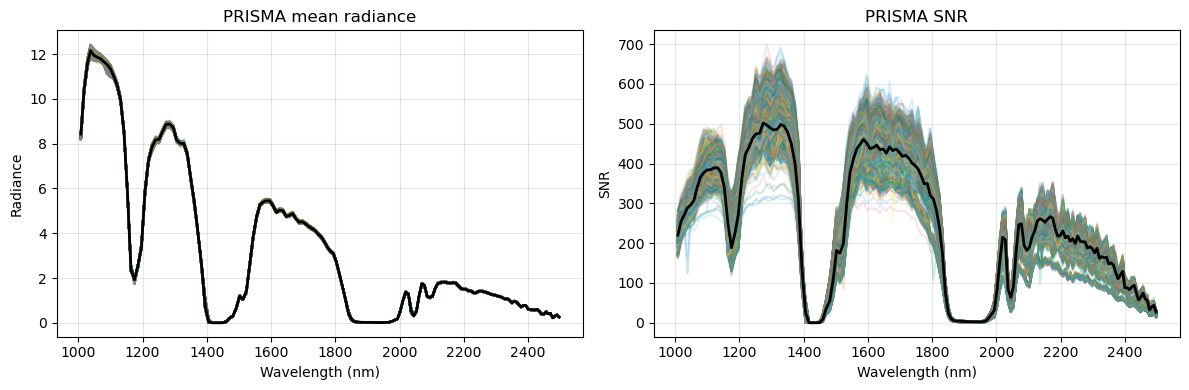


EnMAP reference: /mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/enmap/L1B-DT0000001584_20220712T104302Z_001_V010502_20251017T093724Z/snr_reference_columnwise.npz
  bands: 123 columns: 1000
  wavelength range: 1004.2100219726562 → 2445.530029296875
  SNR min/median/max: 0.9390646815299988 311.4345397949219 742.798095703125
  SNR < 5: 2356
  NaNs: 0


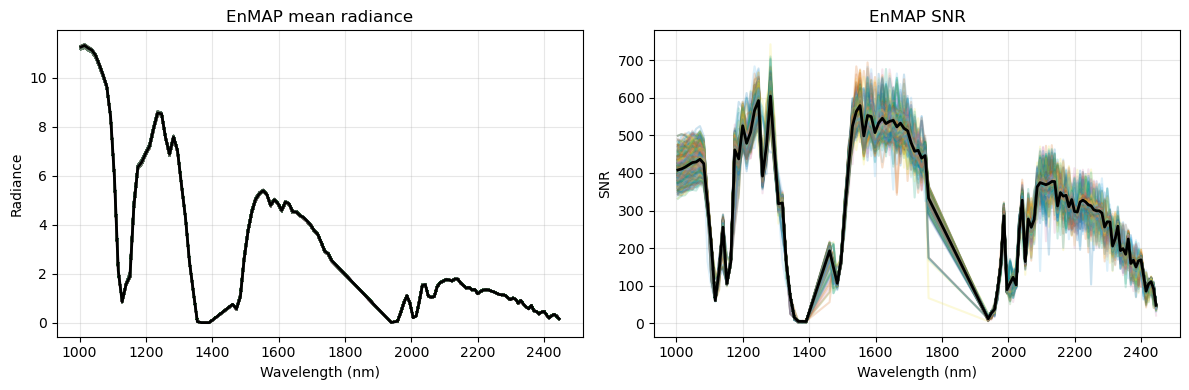

In [7]:
import matplotlib.pyplot as plt

def summarise_reference(path, label):
    ref = noise.ColumnwiseSNRReference.load(path)
    snr = ref.snr
    mu = ref.mean_radiance
    wl = ref.band_nm
    print(f'\n{label} reference: {path}')
    print('  bands:', wl.shape[0], 'columns:', snr.shape[1])
    print('  wavelength range:', float(np.nanmin(wl)), '→', float(np.nanmax(wl)))
    print('  SNR min/median/max:', float(np.nanmin(snr)), float(np.nanmedian(snr)), float(np.nanmax(snr)))
    print('  SNR < 5:', int(np.sum(snr < 5)))
    print('  NaNs:', int(np.isnan(snr).sum()))
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(wl, mu, alpha=0.25)
    axes[0].plot(wl, np.nanmedian(mu, axis=1), color='k', lw=2, label='median')
    axes[0].set_title(f'{label} mean radiance')
    axes[0].set_xlabel('Wavelength (nm)')
    axes[0].set_ylabel('Radiance')
    axes[0].grid(alpha=0.3)
    axes[1].plot(wl, snr, alpha=0.2)
    axes[1].plot(wl, np.nanmedian(snr, axis=1), color='k', lw=2, label='median')
    axes[1].set_title(f'{label} SNR')
    axes[1].set_xlabel('Wavelength (nm)')
    axes[1].set_ylabel('SNR')
    axes[1].set_yscale('linear')
    axes[1].grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

summarise_reference(prisma_ref_path, 'PRISMA')
summarise_reference(enmap_ref_path, 'EnMAP')



### Scene loading & diagnostics helpers

- `load_scene` reads the hyperspectral cubes on first use and caches them, avoiding repeated I/O for smile/striping analyses.
- `_load_prisma` / `_load_enmap` leverage repository readers to obtain radiance cubes, centre-wavelength matrices/vectors, FWHM information, and metadata. Radiance cubes are shaped `(bands, rows, cols)` and consistent across sensors.
- `prisma_smile_profile` and `enmap_smile_profile` locate the band nearest the requested wavelength and return \(\Delta\lambda(x)\) traces plus summary statistics (max excursion, point-to-point swing, standard deviation). These highlight detector smile behaviour without running the full plotting scripts.
- `compute_striping_metrics` quantifies striping strength via FFT peak amplitude/frequency and column-wise variance statistics (median, 95th percentile, ratio). Optional ROIs allow targeting homogeneous subsets where striping is easier to diagnose.
- Caching and shared helpers ensure that smile and striping diagnostics operate on the same data cubes used for the SNR computation context.


In [8]:
snr_comparisons = build_snr_comparisons(DEFAULT_SNR_CASES, aggregation=SNR_AGGREGATION)
snr_summary = summarise_snr_cases(snr_comparisons)
snr_summary


,case,bands,median_ratio@50%,median_ratio@90%,scaled_prisma_median,enmap_median
0,D,122,1.595799,1.295486,243.233333,378.998287


#### Reading the comparison tables
`build_snr_comparisons` aligns PRISMA SNR curves to the EnMAP wavelength grid, applies the brightness normalisation factor $\sqrt{L_{EnMAP}/L_{PRISMA}}$, and aggregates percentiles per wavelength. Inspect the resulting DataFrames to understand how scaled PRISMA SNR tracks EnMAP (ratios near 1) versus where photon statistics or striping drive divergences.



#### Interpreting the SNR summary

The table reports, for case D:

- **bands**: number of wavelength samples remaining after aligning PRISMA to the EnMAP grid (interpolation happens on PRISMA; EnMAP stays native). Very low counts indicate little spectral overlap.
- **median_ratio@50% / @90%**: ratio of EnMAP to scaled PRISMA SNR (respectively using median and 90th percentile SNR). Values close to 1 suggest similar performance; >1 implies EnMAP still retains higher SNR, whereas <1 indicates the scaling may over-predict PRISMA’s SNR.
- **scaled_prisma_median / enmap_median**: overall medians of the scaled PRISMA and EnMAP median SNR curves. These reveal absolute SNR level differences even if ratios look unity.
- **How to use it**: Look for systematic deviations (e.g., EnMAP median exceeding scaled PRISMA by >10%) to flag wavelengths worth deeper inspection in the detailed plots.


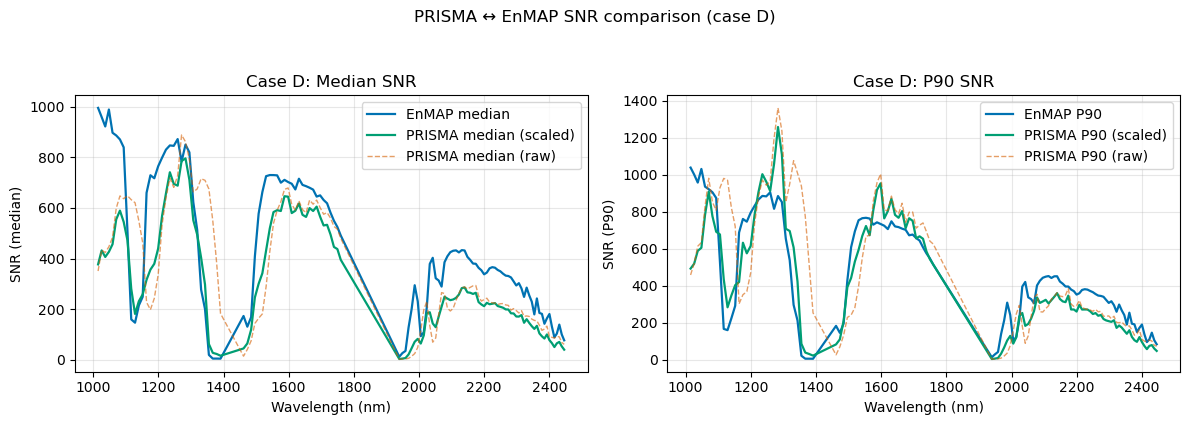

In [9]:
for case, df in snr_comparisons.items():
    plot_snr_case(df, case)



#### Reading the SNR plots

Left: median SNR curves. Right: 90th percentile SNR. Each panel shows:

- **EnMAP** solid lines (reference) derived from the case-D columnwise PCA residual.
- **PRISMA scaled** solid lines after brightness adjustment; ideally overlapping EnMAP if photon-noise scaling holds.
- **PRISMA raw** dashed curves before scaling (context for how much the brightness correction shifts PRISMA).

**Interpretation hints**
- Observe whether scaling removes the offset between PRISMA and EnMAP. Residual gaps could point to calibration differences or non-photon noise contributions.
- Check for wavelength-dependent divergence (e.g., scaling works in VNIR but fails in SWIR). Such patterns may correlate with smile or striping behaviour.
- When the scaled curve crosses the EnMAP curve, investigate the corresponding radiance means (`mu`) to ensure interpolation did not introduce artefacts.


In [10]:
prisma_scene = load_scene("prisma")
enmap_scene = load_scene("enmap")

smile_rows = []
smile_profiles = []
for target_nm in SCENE_CONFIG["prisma"]["smile_targets_nm"]:
    x_p, delta_p, stats_p = prisma_smile_profile(prisma_scene, target_nm)
    stats_p["sensor"] = "PRISMA"
    smile_rows.append(stats_p)
    smile_profiles.append(("PRISMA", target_nm, x_p, delta_p, stats_p["band_nm"]))

    x_e, delta_e, stats_e = enmap_smile_profile(enmap_scene, target_nm)
    stats_e["sensor"] = "EnMAP"
    smile_rows.append(stats_e)
    smile_profiles.append(("EnMAP", target_nm, x_e, delta_e, stats_e["band_nm"]))

smile_summary = pd.DataFrame(smile_rows)
smile_summary


,band_index,band_nm,target_nm,max_abs_delta_nm,p2p_delta_nm,std_delta_nm,sensor,domain,local_idx
0,66,998.492849,1000.0,3.278452,6.075317,1.758875,PRISMA,NaN,NaN
1,102,1004.210000,1000.0,0.258750,0.486314,0.163015,EnMAP,SWIR,11.0
2,127,1647.206315,1650.0,4.087508,7.229004,2.099664,PRISMA,NaN,NaN
3,153,1653.330000,1650.0,0.487843,0.671844,0.194582,EnMAP,SWIR,62.0
4,202,2298.265802,2300.0,2.572686,4.879395,1.411200,PRISMA,NaN,NaN
5,205,2298.420000,2300.0,0.528145,0.716721,0.181466,EnMAP,SWIR,114.0



#### Smile metrics table

For each target wavelength the table lists:

- **band_index / band_nm**: selected band indices and nominal centres per sensor after nearest-band lookup.
- **max_abs_delta_nm**: worst-case deviation from the band-mean centre wavelength (magnitude of smile). Values above ~0.5–1 nm indicate noticeable shifts.
- **p2p_delta_nm**: total swing across the detector; compare sensors to see which exhibits larger column-wise drift.
- **std_delta_nm**: spread of \(\Delta\lambda(x)\); higher values imply a broader distribution of per-column offsets.
- **Interpretation tip**: Larger excursions may depress SNR by broadening the spectral response and misaligning calibration; cross-reference with SNR residuals at similar wavelengths.


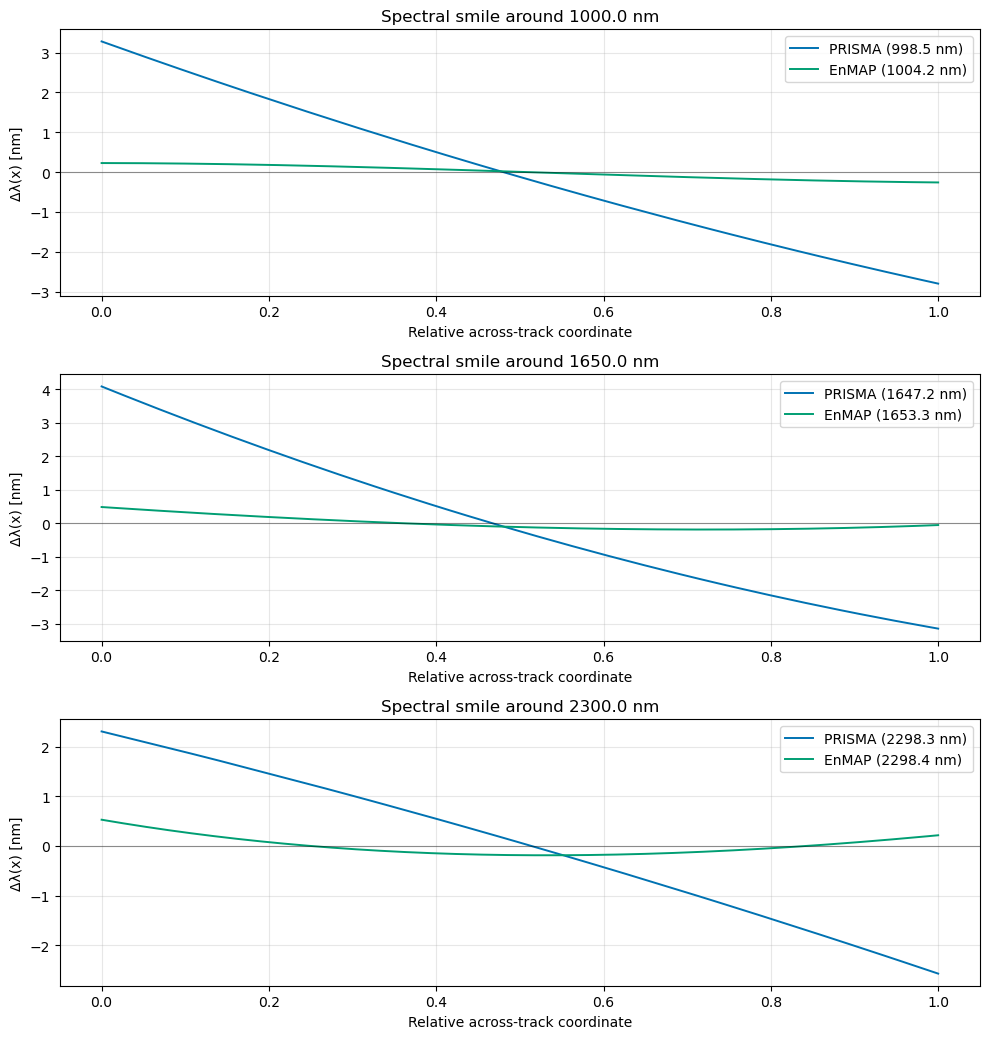

In [11]:
unique_targets = sorted({entry[1] for entry in smile_profiles})
fig, axes = plt.subplots(len(unique_targets), 1, figsize=(10, 3.5 * len(unique_targets)), sharex=False)
if len(unique_targets) == 1:
    axes = [axes]

for ax, target_nm in zip(axes, unique_targets):
    for sensor, tgt, x_rel, delta, band_nm in smile_profiles:
        if not np.isclose(tgt, target_nm):
            continue
        ax.plot(x_rel, delta, label=f"{sensor} ({band_nm:.1f} nm)", lw=1.4)
    ax.axhline(0.0, color="k", lw=0.8, alpha=0.4)
    ax.set_xlabel("Relative across-track coordinate")
    ax.set_ylabel("Δλ(x) [nm]")
    ax.set_title(f"Spectral smile around {target_nm:.1f} nm")
    ax.grid(alpha=0.3)
    ax.legend()

fig.tight_layout()
plt.show()



#### Spectral smile plots

\(\Delta\lambda(x)\) curves are traced against the relative across-track coordinate (0 = left edge, 1 = right edge). Compare PRISMA vs EnMAP:

- Flat curves imply minimal smile and stable band centres.
- Monotonic slopes signal dispersion mismatches across the focal plane; note whether both sensors lean in the same direction.
- Larger oscillations or higher amplitude (especially at edges) reveal stronger smile; correlate with `max_abs_delta_nm` and `p2p_delta_nm` from the table.
- Legends include the actual band centre, highlighting if the sensors probe slightly different wavelengths despite targeting the same nominal spectral point.


In [12]:
striping_rows = []
for sensor_name, scene in (("prisma", prisma_scene), ("enmap", enmap_scene)):
    roi_spec = SCENE_CONFIG[sensor_name].get("striping_roi")
    for target_nm in STRIPING_TARGETS_NM:
        try:
            metrics = compute_striping_metrics(scene, target_nm, roi_spec=roi_spec)
        except ValueError:
            continue
        metrics["sensor"] = sensor_name.upper()
        striping_rows.append(metrics)

striping_df = pd.DataFrame(striping_rows)
striping_df


,band_index,band_nm,target_nm,stripe_peak_db,stripe_peak_freq_cyc_per_px,column_std_median,column_std_p95,column_std_ratio,row_std_median,global_std,sensor
0,90,1251.352282,1250.0,18.752874,0.500,0.325645,0.328470,1.008677,0.072236,0.330333,PRISMA
1,127,1647.206315,1650.0,27.024539,0.002,0.177341,0.180464,1.017610,0.032912,0.178700,PRISMA
2,189,2198.860038,2200.0,18.232447,0.006,0.045831,0.048452,1.057179,0.015724,0.047424,PRISMA
3,123,1247.310000,1250.0,26.779882,0.002,0.041855,0.067423,1.610894,0.053270,0.055234,ENMAP
4,153,1653.330000,1650.0,25.427450,0.002,0.020072,0.034793,1.733442,0.030613,0.031403,ENMAP
5,193,2199.710000,2200.0,23.008127,0.002,0.007156,0.011955,1.670515,0.010938,0.011625,ENMAP



#### Striping metrics table

Key fields:

- **stripe_peak_db**: FFT peak relative to baseline. Readings >5–6 dB typically denote visible striping; near-zero suggests flat spectra.
- **stripe_peak_freq_cyc_per_px**: location of the dominant stripe frequency (cycles/pixel). Consistent frequencies across sensors may hint at scene-driven artefacts, while differing ones imply instrument-specific behaviour.
- **column_std_median / column_std_p95 / column_std_ratio**: column-to-column variability. Ratios >>1 indicate heavy stripe variance; values ~1 imply uniformity.
- **row_std_median & global_std**: complementary context for along-track variability and overall band noise level.
- **Use alongside SNR**: Strong striping (high peak dB, high column std ratio) can inflate columnwise sigma estimates, explaining degraded SNR.


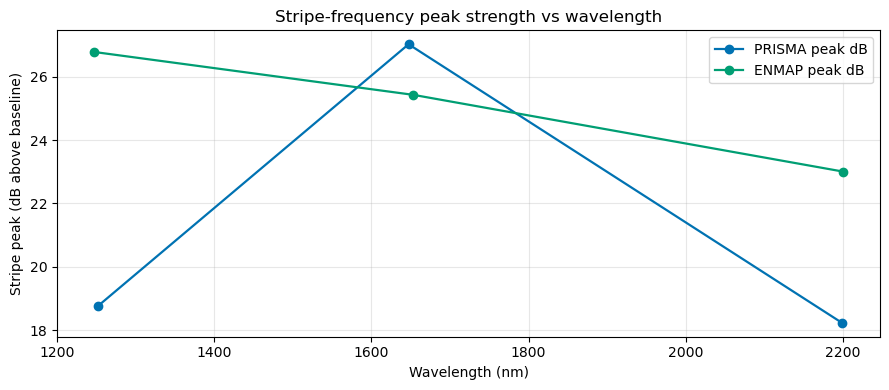

In [13]:
if not striping_df.empty:
    fig, ax = plt.subplots(1, 1, figsize=(9, 4))
    for sensor in striping_df["sensor"].unique():
        sub = striping_df[striping_df["sensor"] == sensor]
        ax.plot(sub["band_nm"], sub["stripe_peak_db"], marker="o", lw=1.6, label=f"{sensor} peak dB")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Stripe peak (dB above baseline)")
    ax.set_title("Stripe-frequency peak strength vs wavelength")
    ax.grid(alpha=0.3)
    ax.legend()
    fig.tight_layout()
    plt.show()
else:
    print("No striping metrics computed (check STRIPING_TARGETS_NM range).")



#### Stripe peak plot

This plot tracks how the FFT stripe peak (dB) varies with wavelength. Compare sensors to assess:

- Whether stripes concentrate in particular spectral regions (e.g., SWIR only).
- How strongly the peak rises above baseline; >10 dB usually signals severe striping.
- Stability of the stripe frequency across wavelengths—consistent peaks imply a well-defined stripe mode, while erratic values may reflect weak or noise-driven detections.
- Combine with the column variance ratios: elevated peaks paired with high ratios strengthen the case for destriping or adaptive masking at those wavelengths.


In [17]:
import numpy as np
import scripts.core.targets as targets
from scripts.core import noise

ref = noise.ColumnwiseSNRReference.load("/mnt/d/Lavoro/Assegno_Ricerca_Sapienza/CLEAR_UP/CH4_detection/Matched_filter_approach/hygas/notebooks/outputs/prisma/20200401085313/snr_reference_columnwise.npz")
#wl_full = np.nanmean(scene["cw_matrix"], axis=0)   # same array select_band_indices uses
#band_indices_run = targets.select_band_indices(wl_full, 2100, 2450)

print("Reference detector bands:", ref.band_indices[:10], "…")
#print("Bands used in this run:", band_indices_run[:10], "…")
#print("Missing:", set(band_indices_run) - set(ref.band_indices))


Reference detector bands: [66 67 68 69 70 71 72 73 74 75] …
